# Loans data

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt

In [2]:
loan_df = pd.read_csv('../data/loan_data.csv', parse_dates=[
                      'DATE_OF_BIRTH', 'DISBURSAL_DATE'], infer_datetime_format=True)

We are not doing the feature parsing to integer columns as we did in the chapter here, although it would be best to do so (e.g. parsing the strings to dates and getting seconds since the epoch for dates).

In [3]:
numeric_columns = [c for c in loan_df.columns if is_numeric_dtype(loan_df[c]) and c != 'LOAN_DEFAULT']

In [4]:
from sklearn.feature_selection import f_classif

f_scores, p_values = f_classif(loan_df[numeric_columns], loan_df['LOAN_DEFAULT'])

C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\words\Anaconda3\envs\datasci\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


array([<AxesSubplot:title={'center':'f_scores'}>,
       <AxesSubplot:title={'center':'p_values'}>], dtype=object)

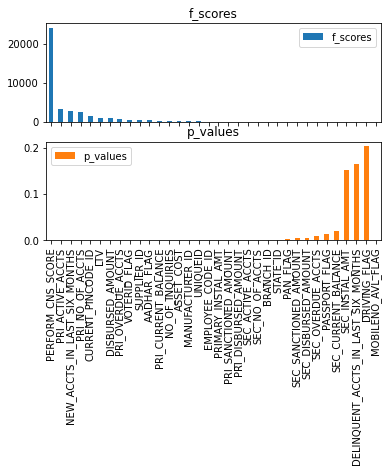

In [5]:
anova_df = pd.DataFrame({'f_scores': f_scores, 'p_values': p_values}, index=numeric_columns)
anova_df.sort_values(by='f_scores', inplace=True, ascending=False)
anova_df.plot.bar(subplots=True)

We can see the credit score (CNS score) has the highest F-score by far, so seems to be the most important from this analysis. Only the last 4 features (SEC_INSTAL_AMT onward) have p-values above 0.05, so these appear to not be strongly related to the target variable. The MOBILENO_AVL_FLAG has only one value, so the p-value cannot be computed (it is nan).

<AxesSubplot:>

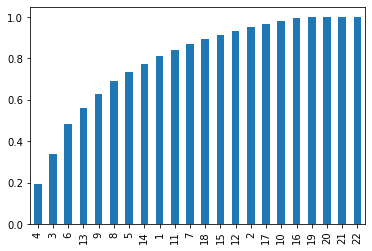

In [6]:
(loan_df['STATE_ID'].value_counts().cumsum() / loan_df.shape[0]).plot.bar()

It looks like we have 50% of the data covered with the first 3 state IDs, and the slope begins to flatten out a little there. We will choose the top 3 states to keep

In [7]:
loan_df.loc[~loan_df['STATE_ID'].isin([4, 3, 6]), 'STATE_ID'] = 'other'

In [8]:
state_ohe = pd.get_dummies(loan_df['STATE_ID'], prefix='STATE_ID', prefix_sep='=').drop('STATE_ID=other', axis=1)
full_df = pd.concat([loan_df, state_ohe], axis=1)
full_df

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,STATE_ID=3,STATE_ID=4,STATE_ID=6
0,643538,48349,65210,76.68,3,16092,51,51,1981-12-20,Salaried,...,0,0,0,0yrs 0mon,0yrs 0mon,0,0,0,0,0
1,595627,55159,62972,88.93,72,16682,45,475,1976-01-01,Self employed,...,0,0,0,0yrs 0mon,0yrs 0mon,0,1,0,0,0
2,586518,67882,113530,61.66,7,23091,51,5858,1992-03-26,Self employed,...,0,0,0,0yrs 0mon,0yrs 0mon,0,0,1,0,0
3,491581,55613,69807,85.95,103,20285,86,6995,1997-01-01,Self employed,...,0,0,0,0yrs 0mon,0yrs 0mon,0,1,0,0,0
4,614684,46249,67645,70.22,67,18129,45,1511,1980-02-22,Salaried,...,0,0,0,0yrs 0mon,0yrs 0mon,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133149,627837,63213,75976,84.24,136,23672,45,3773,1980-04-03,Self employed,...,0,0,0,0yrs 0mon,0yrs 0mon,0,0,0,0,0
133150,444591,48549,98000,50.20,2,24261,49,1670,1996-04-30,Salaried,...,0,0,0,0yrs 0mon,0yrs 0mon,0,0,0,1,0
133151,598150,62613,71751,89.75,3,17339,51,551,1990-01-01,Self employed,...,0,0,0,0yrs 7mon,0yrs 7mon,3,0,0,0,0
133152,474968,48803,60641,83.28,61,15919,45,1377,1985-05-22,Self employed,...,0,0,0,0yrs 0mon,0yrs 0mon,0,1,0,0,1


In [10]:
loan_df['day_of_week_disb'] = loan_df['DISBURSAL_DATE'].dt.dayofweek.astype('category')

In [11]:
import phik

print(phik.phik_from_array(loan_df['day_of_week_disb'], loan_df['LOAN_DEFAULT']))
# currently need to set the drop over/underflow to false to avoid error. Should be fixed soon in an update
print(phik.significance.significance_from_array(loan_df['day_of_week_disb'], loan_df['LOAN_DEFAULT'],
                                                drop_overflow=False,
                                                drop_underflow=False))

0.011987663057208877
(9.233482904940127e-05, 3.739114428287284)


It looks like the correlation is very weak at 0.01. The p-value is very small (8e-5) so the correlation is significantly different from 0. Due to the weak correlation, we probably don't need this feature.

# Credit card data

In [12]:
cc_df = pd.read_excel('data/default of credit card clients.xls', skiprows=1, index_col=0)

In [13]:
cc_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [14]:
features = cc_df.drop('default payment next month', axis=1)

In [15]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled = ss.fit_transform(features)
pca = PCA()
cc_pca = pca.fit_transform(scaled)

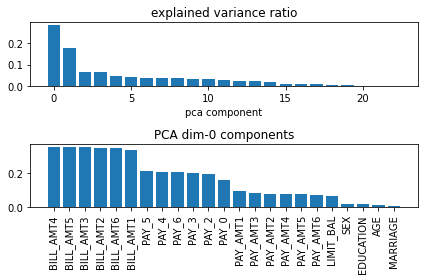

In [17]:
idx = pca.explained_variance_ratio_.argsort()[::-1]
ticks = range(pca.n_components_)
f, ax = plt.subplots(2, 1)
ax[0].bar(ticks, pca.explained_variance_ratio_[idx])
ax[0].set_title('explained variance ratio')
ax[0].set_xlabel('pca component')

comp_idx = abs(pca.components_[0]).argsort()[::-1]
ax[1].bar(ticks, abs(pca.components_[0, comp_idx]))
plt.xticks(ticks, np.array(features.columns)[comp_idx], rotation=90)
ax[1].set_title('PCA dim-0 components')
plt.tight_layout()

Text(0.5, 0, 'pca component')

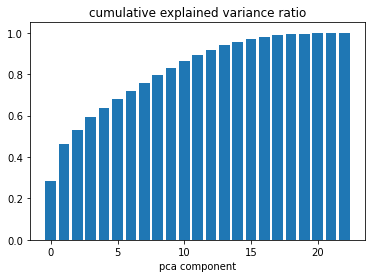

In [18]:
plt.bar(ticks, pca.explained_variance_ratio_[idx].cumsum())
plt.title('cumulative explained variance ratio')
plt.xlabel('pca component')

It looks like around 17 components is a good choice, as the cumulative sum of explained variance flattens out there.